# Problem Definition and Objective

Digital advertising relies on precision,delivering ads to users unlikely to engage results in high ad spend leakage and poor campaign Return on Investment. As ad costs rise, businesses can no longer afford "blind" targeting, they require precision tools to distinguish high-intent users from those unlikely to engage.
However, achieving this precision is technically difficult due to the class imbalance inherent in user behavior data.
In this dataset, the 65:35 ratio (Click vs. No Click) causes traditional linear models, like Logistic Regression, to develop a majority class bias.
The project aims to :
1. Transition from a biased baseline Logistic Regression to a Random Forest algorithm utilizing balanced class weights.
2. Identify predictive drivers and quantify the impact of user features.
3. Identify high-intent segments which have high click probability rate.
4. Evaluate and compare Logistic Regression and Random Forest to identify the superior architecture for overcoming majority class bias and improving minority class detection.








# Data Understanding and Preparation

### About the Dataset

The data used in this analysis is sourced from [Kaggle](https://www.kaggle.com)  
**Source**: [Dataset Link](https://www.kaggle.com/datasets/marius2303/ad-click-prediction-dataset)  
**Format**: CSV

### Dataset Features

The dataset consists of demographic, behavioral, and contextual features used to predict user engagement.

* **id**: A unique identifier assigned to each individual user.
* **full_name**: The user's name, formatted as "UserX" to maintain anonymity.
* **age**: The age of the user, ranging from 18 to 64 years.
* **gender**: The user's gender (Categorized as Male, Female, or Non-Binary).
* **device_type**: The type of device used to view the ad (Mobile, Desktop, or Tablet).
* **ad_position**: The position of the ad on the webpage (Top, Side, or Bottom).
* **browsing_history**: The user's browsing activity prior to seeing the ad (Shopping, News, Entertainment, Education, or Social Media).
* **time_of_day**: The time when the user viewed the ad (Morning, Afternoon, Evening, or Night).
* **click(Target)**: The target label indicating whether the user clicked on the ad (1 for a click, 0 for no click).



In [11]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# load the data

data=pd.read_csv("ad_click_dataset.csv")
data.head()


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


### Basic Data Exploration

In [14]:
# Display Basic Information

print("Dataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


In [15]:
# Information on Numerical features of the data

data.describe()


,id,age,click
count,10000.000000,5234.000000,10000.000000
mean,5060.211400,40.197363,0.650000
std,2861.758265,13.126420,0.476993
min,5.000000,18.000000,0.000000
25%,2529.000000,29.000000,0.000000
50%,5218.000000,39.500000,1.000000
75%,7466.000000,52.000000,1.000000
max,10000.000000,64.000000,1.000000


In [16]:
# Information on Categorical features of the data

data.describe(include=['object'])

,full_name,gender,device_type,ad_position,browsing_history,time_of_day
count,10000,5307,8000,8000,5218,8000
unique,4000,3,3,3,5,4
top,User1171,Female,Desktop,Bottom,Entertainment,Morning
freq,25,1834,2754,2817,1175,2126


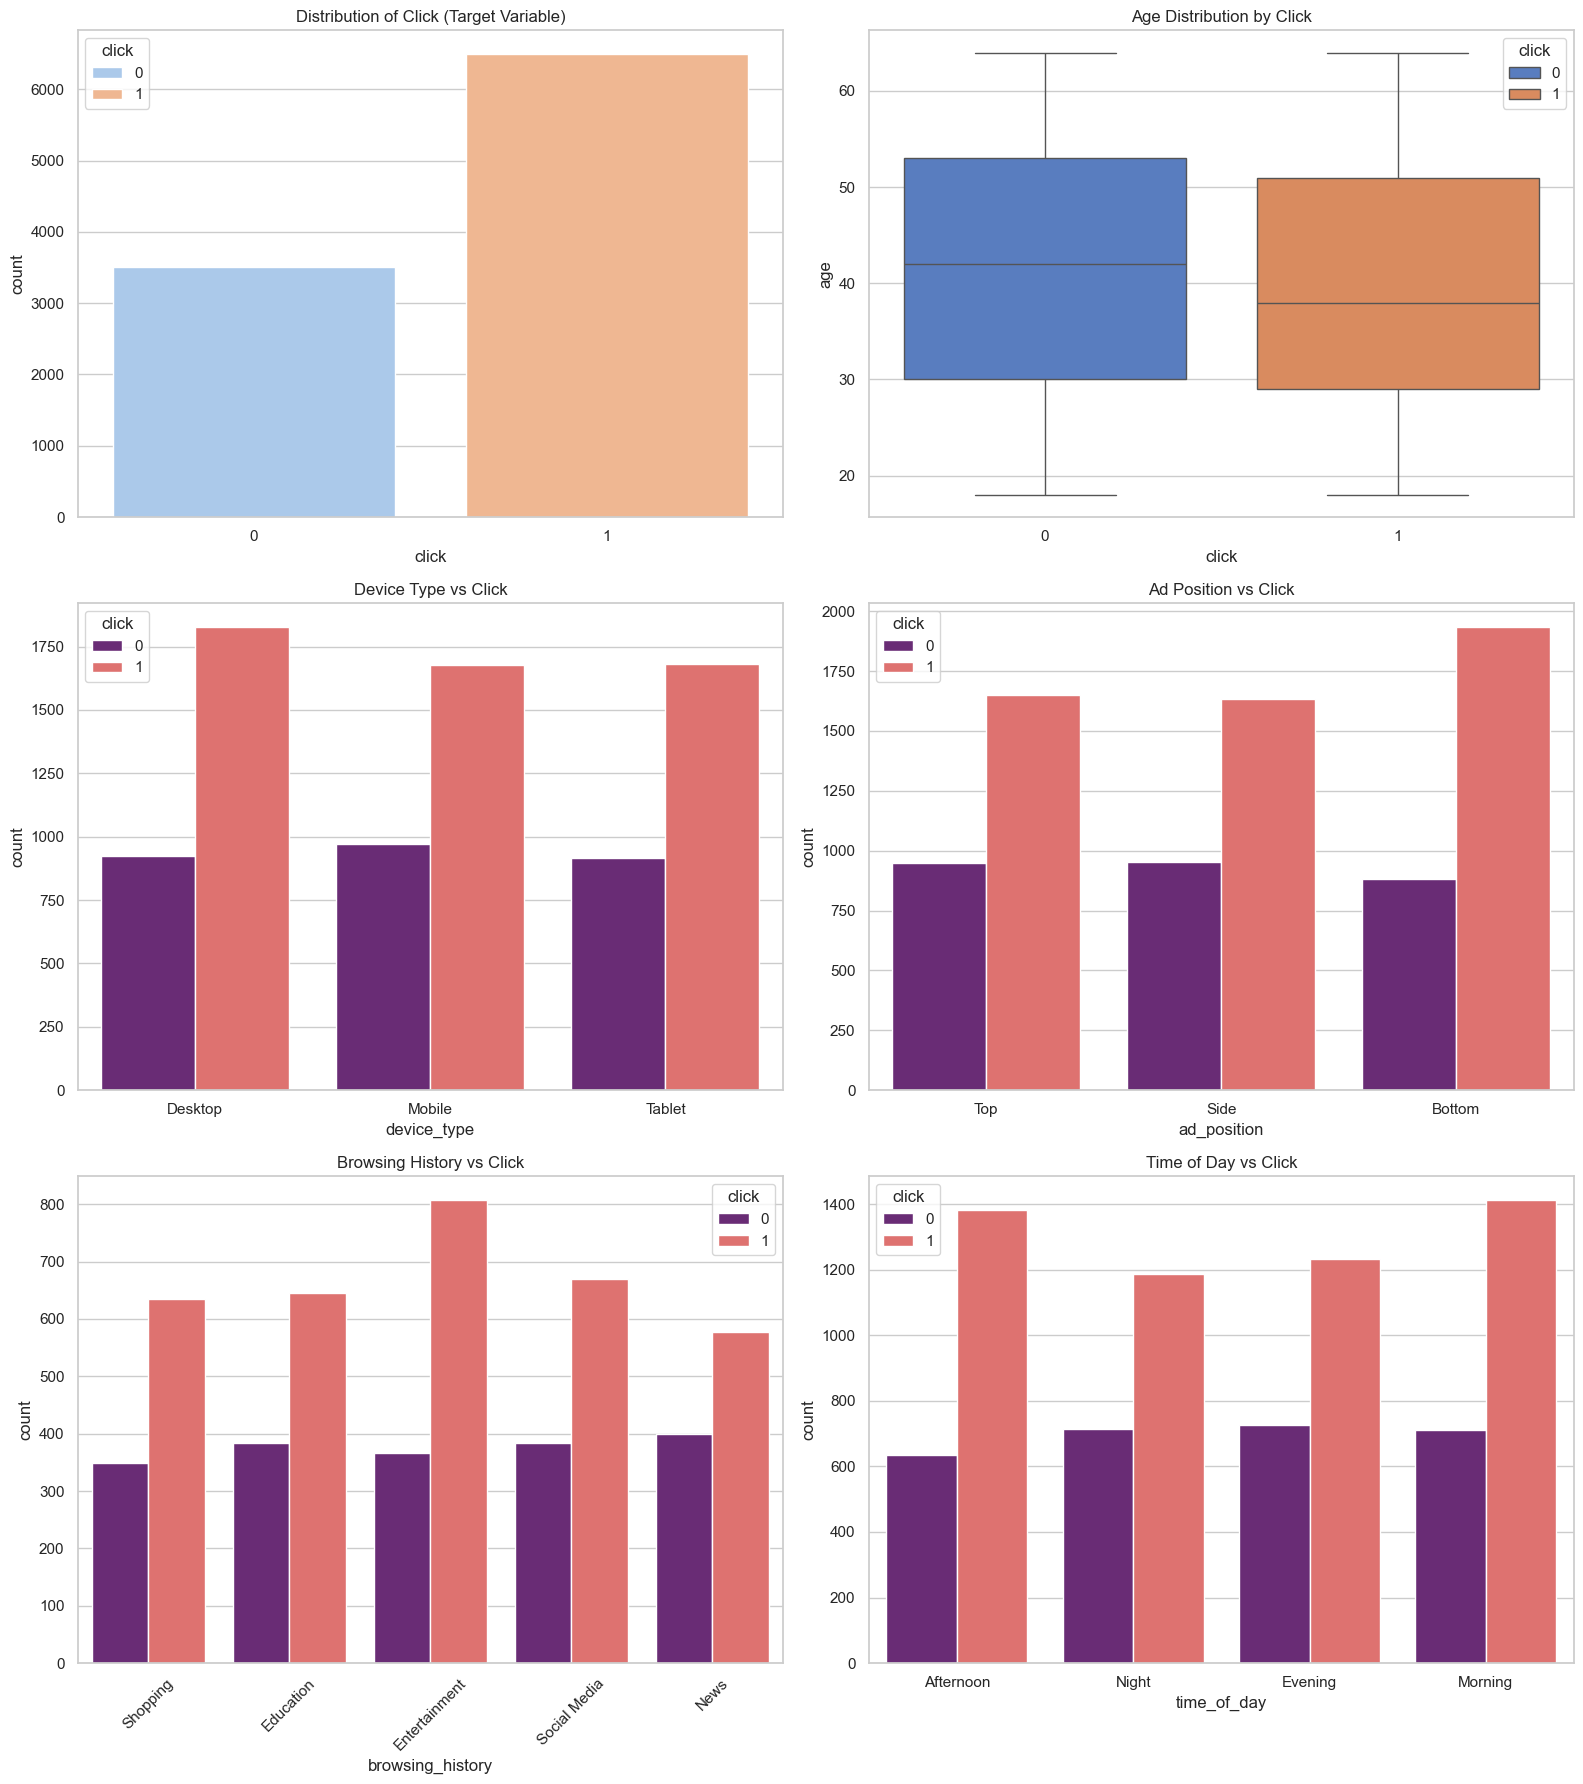

In [19]:
# Basic Visualization

# Set the style
sns.set_theme(style="whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Click distribution (Target)
sns.countplot(ax=axes[0, 0], x='click', data=data,hue='click', palette='pastel')
axes[0, 0].set_title('Distribution of Click (Target Variable)')

# 2. Age vs Click
sns.boxplot(ax=axes[0, 1], x='click', y='age',hue='click', data=data, palette='muted')
axes[0, 1].set_title('Age Distribution by Click')

# 3. Device Type vs Click
sns.countplot(ax=axes[1, 0], x='device_type', hue='click', data=data, palette='magma')
axes[1, 0].set_title('Device Type vs Click')

# 4. Ad Position vs Click
sns.countplot(ax=axes[1, 1], x='ad_position', hue='click', data=data, palette='magma')
axes[1, 1].set_title('Ad Position vs Click')

# 5. Browsing History vs Click
sns.countplot(ax=axes[2, 0], x='browsing_history', hue='click', data=data, palette='magma')
axes[2, 0].set_title('Browsing History vs Click')
axes[2, 0].tick_params(axis='x', rotation=45)

# 6. Time of Day vs Click
sns.countplot(ax=axes[2, 1], x='time_of_day', hue='click', data=data, palette='magma')
axes[2, 1].set_title('Time of Day vs Click')

plt.tight_layout()


### Handling Missing Values

**For numerical features** :
We observe that the distribution of age has a significant number of outliers, so we replace the missing values for the 'age' feature by the median.

**For categorical features** : Replacing the missing values with a new category labelled 'Unknown' as replacing with mode would be biased.




In [21]:
# Calculating the number of missing values

data.isnull().sum()

age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

<Axes: xlabel='age', ylabel='Count'>

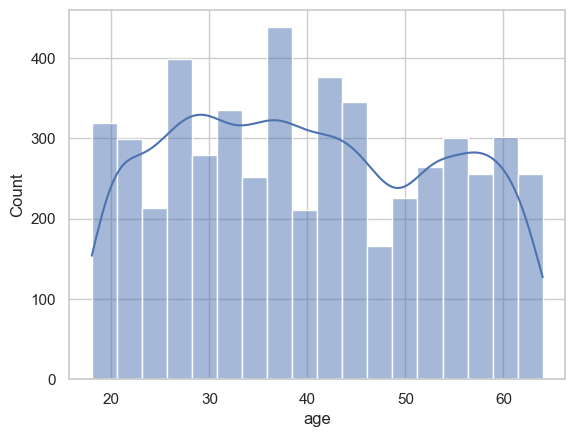

In [22]:
# Distribution of 'Age'

sns.histplot(data=data,x="age",kde=True)

<Axes: ylabel='age'>

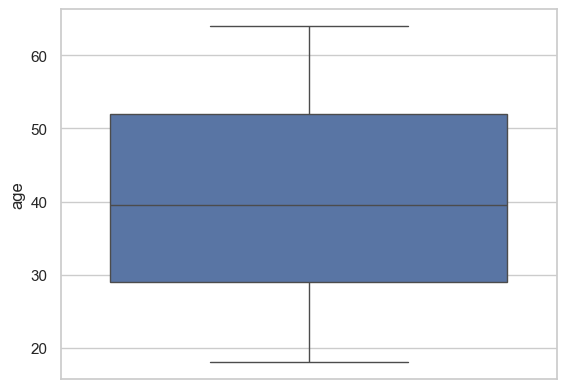

In [23]:
# Checking Outliers through Boxplot

sns.boxplot(data=data,y="age")

In [24]:
#Filling missing values in numerical features

data['age']=data['age'].fillna(data['age'].median())

#Filling missing values in categorical features

data['gender']=data['gender'].fillna('Unknown')
data['browsing_history']=data['browsing_history'].fillna('Unknown')
data['time_of_day']=data['time_of_day'].fillna('Unknown')
data['device_type']=data['device_type'].fillna('Unknown')
data['ad_position']=data['ad_position'].fillna('Unknown')
data


,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon,1
1,39.5,Male,Desktop,Top,Unknown,Unknown,1
2,41.0,Non-Binary,Unknown,Side,Education,Night,1
3,34.0,Male,Unknown,Unknown,Entertainment,Evening,1
4,39.0,Non-Binary,Unknown,Unknown,Social Media,Morning,0
...,...,...,...,...,...,...,...
9995,39.5,Unknown,Mobile,Top,Education,Unknown,0
9996,39.5,Female,Desktop,Bottom,Entertainment,Unknown,0
9997,39.5,Male,Mobile,Side,Unknown,Morning,0
9998,39.5,Unknown,Desktop,Unknown,Shopping,Morning,1


In [25]:
# Checking whether the target variable 'click' is balanced or imbalanced

# Check raw counts
class_counts=data['click'].value_counts()
print(class_counts)


click
1    6500
0    3500
Name: count, dtype: int64


Text(0.5, 1.0, 'Class Distribution - Pie Chart')

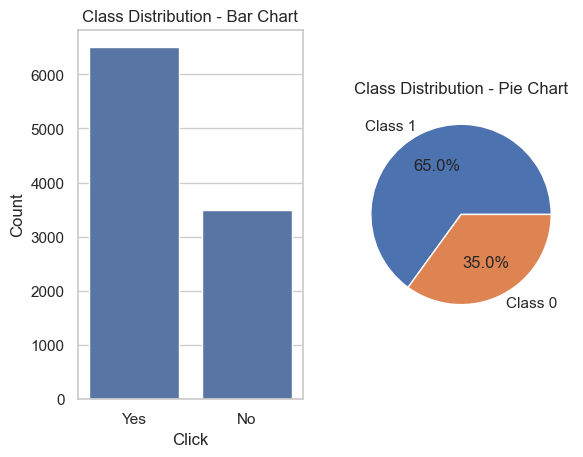

In [26]:
# Visualizing the class imbalance through Bar Plot and Pie Chart

# 1. Bar plot

labels=["Yes","No"]
class_count=[6500,3500]

plt.subplot(1,2,1)
sns.barplot(x=labels,y=class_count)
plt.title("Class Distribution - Bar Chart")
plt.xlabel("Click")
plt.ylabel("Count")

# 2. Pie Chart

class_counts = data['click'].value_counts()
plt.subplot(1,2,2)
plt.pie(class_counts, labels=['Class 1', 'Class 0'],autopct='%1.1f%%')
plt.title('Class Distribution - Pie Chart')


### Feature Selection
Removing 'id' and 'full_name' columns as they are unique identifiers and don't provide predictive power.

In [ ]:
# Dropping the identifiers

data=data.drop(columns=['id','full_name'])
data.head()


### Feature Engineering ( One-hot encoding here )
Categorical variables are converted into numbers using One-Hot Encoding so the model could process them.

In [27]:
# One hot encoding

from sklearn.preprocessing import OneHotEncoder

# 1. Define the categorical columns
categorical_cols = ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']

# 2. Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 3. Fit and Transform the categorical columns
encoded_data = encoder.fit_transform(data[categorical_cols])

# 4. Convert back to a DataFrame with clear column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols)
print("Encoded data frame")
print(df_encoded)

# 5. Combine with 'age' and the target 'click'
df_final = pd.concat([data[['age', 'click']], df_encoded], axis=1)

print("Final dataset shape", df_final.shape)
print(df_final.head())


Encoded data frame
      gender_Female  gender_Male  gender_Non-Binary  gender_Unknown  \
0               0.0          0.0                0.0             1.0   
1               0.0          1.0                0.0             0.0   
2               0.0          0.0                1.0             0.0   
3               0.0          1.0                0.0             0.0   
4               0.0          0.0                1.0             0.0   
...             ...          ...                ...             ...   
9995            0.0          0.0                0.0             1.0   
9996            1.0          0.0                0.0             0.0   
9997            0.0          1.0                0.0             0.0   
9998            0.0          0.0                0.0             1.0   
9999            0.0          1.0                0.0             0.0   

      device_type_Desktop  device_type_Mobile  device_type_Tablet  \
0                     1.0                 0.0              

# Model/System design

The project applies Supervised Machine Learning for a Binary Classification task. We use a labeled dataset to train models to predict one of two outcomes: whether a user will click on an ad (1) or not click (0) and with how much probability.

**Architecture Explanation**

The project followed an iterative pipeline to find the most accurate and fair prediction method:

1. Baseline Linear Model: We started with a standard Logistic Regression to see how a simple mathematical formula would handle the data.

2. Weighted Linear Model: We re-ran the Logistic Regression with balanced class weights to try and force the model to pay more attention to the minority group (the 35% who didn't click).

3. Ensemble Learning: Finally, we implemented a Random Forest Algorithm, which uses a "forest" of many decision trees to vote on the final outcome.

# Core Implementation




### Model Training: Logistic Regression (Baseline)

In [85]:
# Running Logistic Regression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Separate Features (X) and Target (y)
X = df_final.drop('click', axis=1)
y = df_final['click']

# 2. Split into 80% Training and 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train the Logistic Regression Model
model = LogisticRegression()

# 5.Cross validation

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation

scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(scores)
print(f"Average Accuracy: {scores.mean()}")

# 6. Final Model Fit

model.fit(X_train_scaled, y_train)

# 7. Make Predictions

y_pred = model.predict(X_test_scaled)

# 8. Model Evaluation

print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))
report = classification_report(y_test, y_pred)
print("\n--- Classification Report ---")
print(report)


[0.648125 0.65125  0.65375  0.65125  0.65    ]
Average Accuracy: 0.650875
Model Accuracy: 64.60%

--- Confusion Matrix ---
[[   5  700]
 [   8 1287]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.38      0.01      0.01       705
           1       0.65      0.99      0.78      1295

    accuracy                           0.65      2000
   macro avg       0.52      0.50      0.40      2000
weighted avg       0.55      0.65      0.51      2000



### Result 

* The model is effectively failing because it has developed a severe bias toward Class 1, essentially guessing "1" for almost every entry.The most significant evidence of failure is the Recall score.
* It is simply predicting "Positive" for almost every row, which allows it to catch all the "1s" by default while completely missing the "0s."
* To eliminate the bias in the model, we re-define the model to include the class_weight parameter and set it to 'balanced'

### Model Training : Logistic Regression (Balanced)

In [31]:
# Re-running Logistic Regression with class_weight as balanced

# 1. Redefine with 'balanced' weights
model = LogisticRegression(class_weight='balanced')

# 2. Re-fit the model
model.fit(X_train_scaled, y_train)

# 3. Get new predictions
y_pred_new = model.predict(X_test_scaled)

# 6. Check the Results
print(f"Model Accuracy: {accuracy_score(y_test, y_pred_new):.2%}")
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred_new))

# 4. Print the new report
print(classification_report(y_test, y_pred_new))

Model Accuracy: 53.95%

--- Confusion Matrix ---
[[376 329]
 [592 703]]
              precision    recall  f1-score   support

           0       0.39      0.53      0.45       705
           1       0.68      0.54      0.60      1295

    accuracy                           0.54      2000
   macro avg       0.53      0.54      0.53      2000
weighted avg       0.58      0.54      0.55      2000



### Result

* The model demonstrates poor performance with an overall accuracy of 53.95%.
*  While it shows a slightly higher precision of 0.68 for Class 1, its precision for Class 0 is very low at 0.39, indicating frequent incorrect negative predictions.
*  The recall across both classes is nearly identical (0.53 and 0.54), and the confusion matrix shows a high volume of misclassifications, specifically 592 false negatives and 329 false positives, confirming the model's inability to reliably distinguish between the two classes.

### Model Training : Random Forest Algorithm

In [102]:
from sklearn.ensemble import RandomForestClassifier

# 1. Define the Model (Using 'balanced' to help with the class imbalance)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# 2. Train the Model
rf_model.fit(X_train_scaled, y_train)

# 3. Predict and Report
y_pred_rf = rf_model.predict(X_test_scaled)


# 5. Evaluation Metrics
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 69.15%

--- Confusion Matrix ---
[[ 350  355]
 [ 262 1033]]
              precision    recall  f1-score   support

           0       0.57      0.50      0.53       705
           1       0.74      0.80      0.77      1295

    accuracy                           0.69      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.68      0.69      0.69      2000



### Result
 * The transition from the baseline model to the Random Forest algorithm has resulted in a significant performance improvement across all key metrics.
 * Overall accuracy increased from 53.95% to 69.15%.
 * The recall for Class 1 jumped from 0.54 to 0.80, showing the Random Forest is highly effective at capturing the majority of positive instances.
 * Precision for the difficult "Class 0" category improved from 0.39 to 0.57, meaning we can have more confidence in negative predictions than before.

### Analyzing Feature Importance

* The Primary Driver: age is by far the most important feature, with an importance score of approximately 0.44.
* The Secondary Factors: Features like gender_Unknown, device_type_Mobile, and device_type_Desktop follow but have significantly lower scores (below 0.05).
* Low Impact Data: Browsing histories and specific ad positions have very little influence on this specific model.

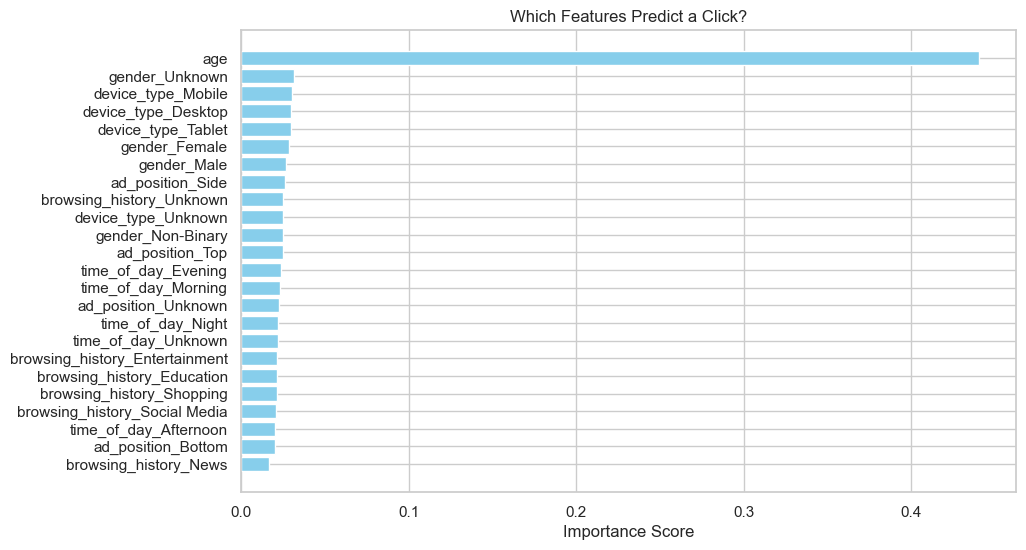

In [100]:
# 1. Get importance scores from the trained Random Forest
importances = rf_model.feature_importances_

# 2. Match scores to column names and sort them
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# 3. Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.title('Which Features Predict a Click?')
plt.xlabel('Importance Score')
plt.show()

### Analyzing how click probabilities change across different age-groups

* Users in the 18–24 age group have the highest click probability at 86.4%.
* The 25–34 age group follows closely with an 83.7% probability.
* Probabilities drop significantly for users over 35, hitting a low of 65.1% in the 35–44 demographic.
* Interestingly, probability rises slightly again in the 55–64 age group to 70.4%.

In [108]:
# 1. Combine Age and Click Probabilities into a DataFrame

probs = rf_model.predict_proba(X_test_scaled)[:, 1]
df_probs = pd.DataFrame({'age': X_test['age'], 'probability': probs})

# 2. Define Age Ranges (Bins)
bins = [18, 25, 35, 45, 55, 65]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64']

# 3. Assign each user to a range
df_probs['age_range'] = pd.cut(df_probs['age'], bins=bins, labels=labels)

# 4. Group by Range and find the Average Probability
age_summary = df_probs.groupby('age_range',observed=False)['probability'].median().reset_index()
print(age_summary)



  age_range  probability
0     18-24     0.864336
1     25-34     0.837523
2     35-44     0.651861
3     45-54     0.664735
4     55-64     0.704590


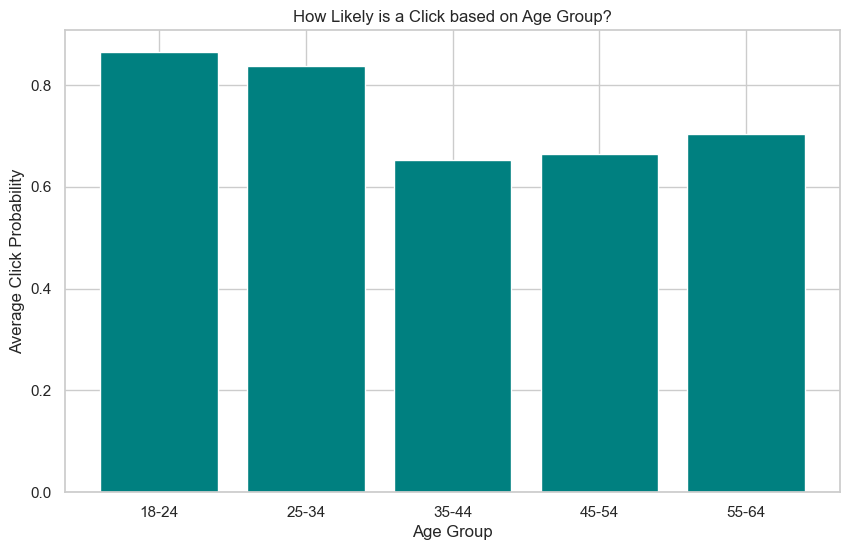

In [110]:
plt.figure(figsize=(10, 6))
plt.bar(age_summary['age_range'], age_summary['probability'], color='teal')
plt.ylabel('Average Click Probability')
plt.xlabel('Age Group')
plt.title('How Likely is a Click based on Age Group?')
plt.show()

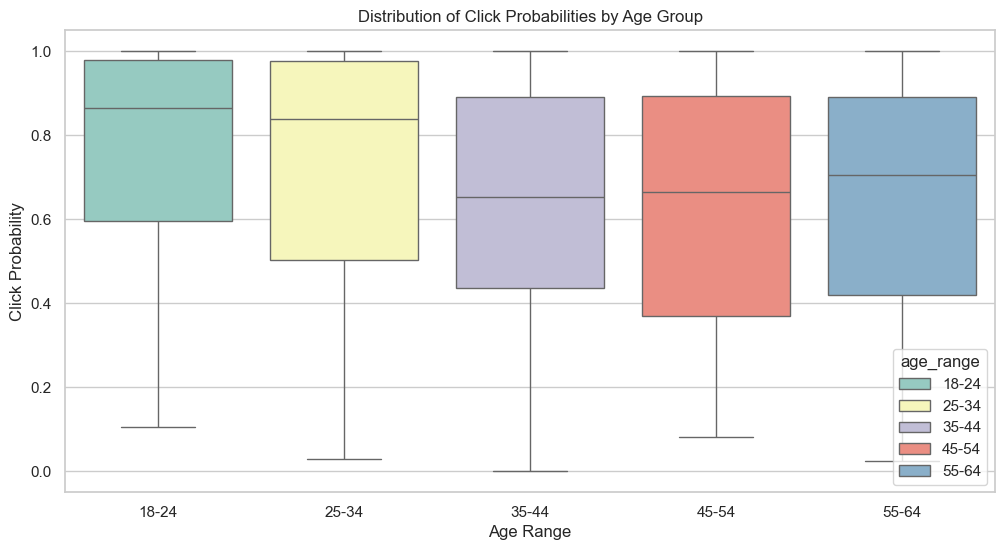

In [37]:
# Visualizing the spread of probabilities within each user age range

plt.figure(figsize=(12, 6))
sns.boxplot(x='age_range', y='probability', data=df_probs, palette='Set3',hue='age_range')
plt.title('Distribution of Click Probabilities by Age Group')
plt.ylabel('Click Probability')
plt.xlabel('Age Range')
plt.show()

# Evaluation and Analysis


* Logistic Regression (Unbalanced): The model was biased, while it looked accurate with an accuracy of 64.60%, it only caught 1% (0.01 Recall) of the people who didn't click.
* Logistic Regression (Balanced): Even after telling the model to be more fair by balancing the weights, the linear model was still too simple to catch the complex patterns of user behaviour.
* Random Forest (Final Model): This was the most efficient model, correctly identifying 50% (0.50 Recall) of non-clickers and 80% (0.80 Recall) of clickers.

# Ethical Considerations and Responsible AI


* The primary ethical challenge in this project was the 65:35 class imbalance.
* Initially, the Logistic Regression model developed a significant bias toward the majority class (Click: Yes).By virtually ignoring the 35% of users who did not click (0.01 Recall), the model was technically unfair to the minority group.
*  To practice Responsible AI, we implemented balanced class weights and eventually transitioned to a Random Forest. This ensured the model was trained to recognize both outcomes, improving the detection of non-clicking users from 0.01 to 0.50 Recall.

# Conclusion and Future Scope

The project attempted to develop a predictive framework for ad-click engagement, navigating from a biased baseline to a high-performance ensemble model.

**Key Insights**
* Model Evolution: While initial Logistic Regression was ineffective due to a 65:35 class imbalance (0.01 Recall for non-clicks), the final Random Forest model achieved a balanced 0.50 Recall for "No Click" and 0.80 Recall for "Click" events.
* The analysis quantified Age as the primary driver of engagement with an importance score of 0.44, specifically identifying the 18–24 demographic as a high-value segment with an 86.4% click probability.

**Possible improvements and Extension**
* Real-Time Deployment: While not covered in the current scope of this project, a vital next step would be to deploy the final Random Forest algorithm via a Streamlit web application. This would transform the model into a functional tool capable of analyzing real-time datasets, allowing marketers to receive instant engagement predictions for real time data.